In [2]:
import load
from load import load as load_images, StockImageDataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cv2 as cv
import random
from tqdm.notebook import tqdm
import math
import matplotlib.image as mimage

images = load_images(slice(0, 16))

0it [00:00, ?it/s]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

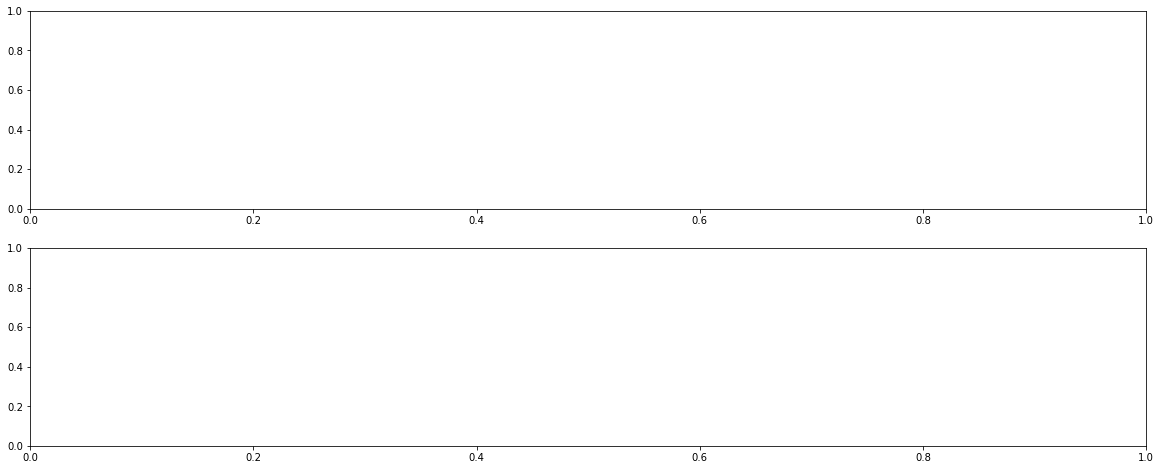

In [3]:
count = load.num_images()
sizes = []
count = 0
batch_size = 100
for i in tqdm(range(0, count, batch_size)):
    s = slice(i, min(count, i + batch_size))
    for im in load_images(s):
        sizes.append(im.shape[:2])
sizes = np.array(sizes)

fig, axs = plt.subplots(2, figsize=(20, 8))
axs[0].boxplot(sizes[:, 0], vert=False)
axs[0].set_title('Height')
axs[1].boxplot(sizes[:, 1], vert=False)
axs[1].set_title('Width')

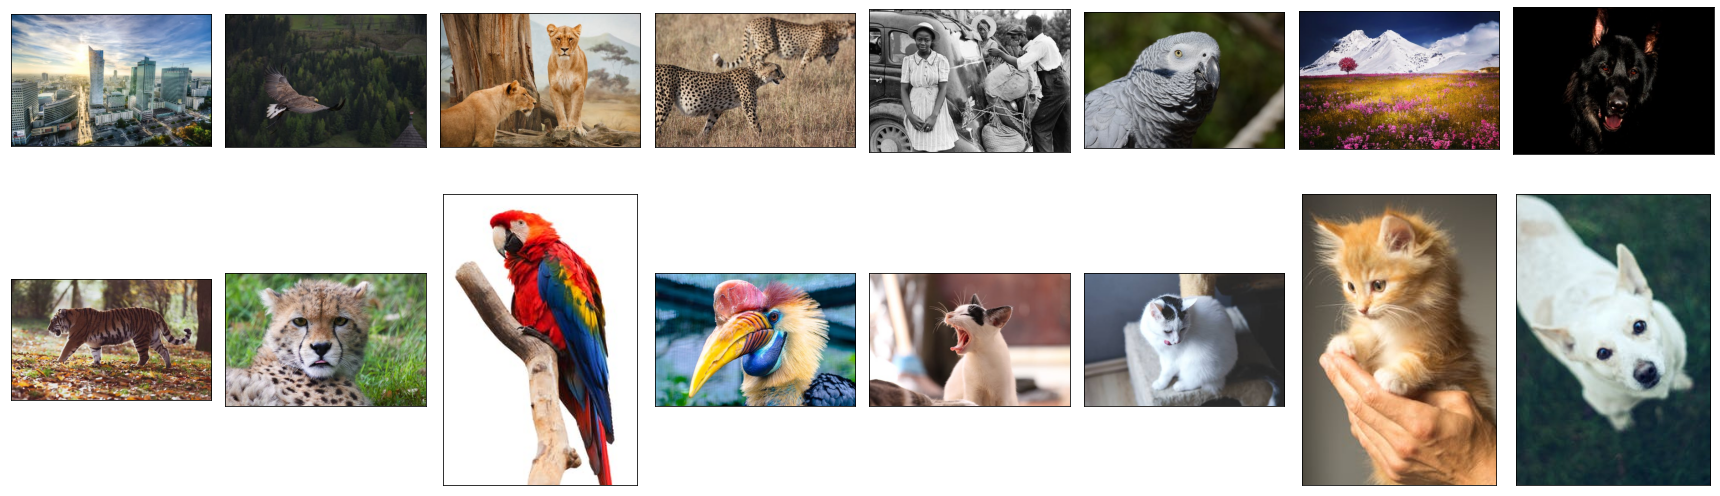

In [ ]:
fig, axs = plt.subplots(2, 8, figsize=(24, 8))
for im, ax in zip(images, axs.ravel()):
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.imshow(im)
fig.tight_layout()

354 46


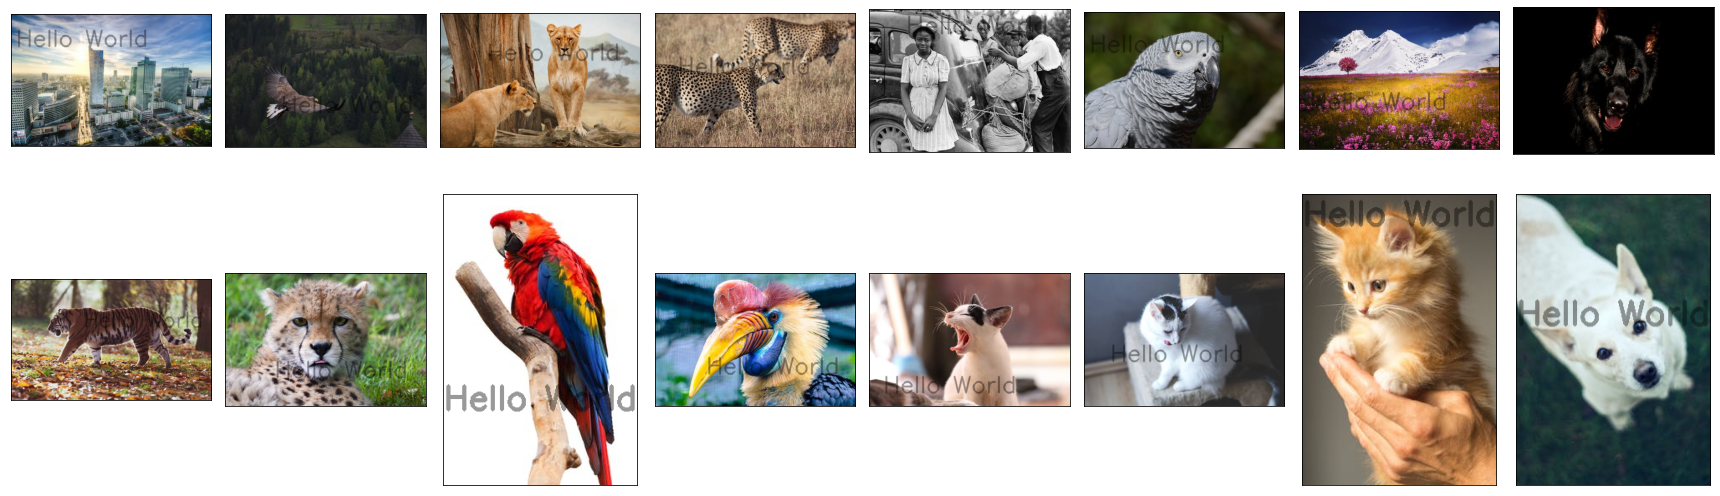

In [4]:
def watermark_size(text):
    text_x, text_y = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 2, 4)[0]
    return text_x+2, text_y+2

def gen_watermark(text, origin, size):
    text_x, text_y = cv.getTextSize(text, cv.FONT_HERSHEY_SIMPLEX, 2, 4)[0]
    if text_x > size[0]:
        scale = 1 * size[0]/text_x
    else:
        scale = 1
    bb_x = int(math.ceil(scale*text_x))+8
    bb_y = int(math.ceil(scale*text_y))+8
    img = np.zeros((bb_y, bb_x), dtype=np.float32)
    img = cv.putText(img, text, (1, bb_y-4), cv.FONT_HERSHEY_SIMPLEX, 2*scale, (1, 1, 1), 4)
    M = np.eye(2, 3)
    origin_array = np.array(list(origin))
    M[:, 2] += origin_array
    img = cv.warpAffine(img, M, size)
    return img, (origin_array, bb_x, bb_y)

TEXT = "Hello World"
watermarks = []
bboxes = []
width, height = watermark_size(TEXT)
print(width, height)
for i, img in enumerate(images):
    x_offset_max = img.shape[1] - width
    x_offset = max(random.random() * x_offset_max, 0)
    y_offset_max = img.shape[0] - height
    y_offset = random.random() * y_offset_max
    watermark, bbox = gen_watermark(TEXT, (x_offset, y_offset), (img.shape[1::-1]))
    watermarks.append(watermark)
    bboxes.append(bbox)

fig, axs = plt.subplots(2, 8, figsize=(24, 8))
for im, wm, ax, bb in zip(images, watermarks, axs.ravel(), bboxes):
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    wmd = im * (1-wm[..., None]*0.4)
    ax.imshow(wmd, cmap='gray')
    # ax.add_patch(mpatches.Rectangle(bb[0], bb[1], bb[2], fill=False))
fig.tight_layout()


In [6]:
# Write out watermark training data

print('WM Patch Size (wxh):', watermark_size(TEXT))
print('Adding 6 for buffer')

def make_16(s, size):
    assert s[1] > s[0]
    dist = s[1] - s[0]
    extra = -dist % 16
    start = s[0] - extra//2
    end = s[1] + extra//2 + extra % 2
    if start >=0 and start < size and end >= 0 and end <= size:
        return slice(start, end)

idx = 0
for i in tqdm(range(load.num_images())):
    img = load.load(slice(i, i+1))[0]
    if img.shape[1] < width:
        continue
    x_offset_max = img.shape[1] - width
    x_offset = random.random() * x_offset_max
    y_offset_max = img.shape[0] - height
    y_offset = random.random() * y_offset_max
    watermark, bbox = gen_watermark(TEXT, (x_offset, y_offset), (img.shape[1::-1]))
    loc = np.round(bbox[0]).astype(np.int64)

    height_slice = make_16((loc[1], loc[1]+bbox[2]), img.shape[0])
    width_slice = make_16((loc[0], loc[0]+bbox[1]), img.shape[1])

    if height_slice is None or width_slice is None:
        continue

    img_crop = img[height_slice, width_slice]
    mimage.imsave(f'cropped/{idx}_nwm.jpg', img_crop)

    wm = img * (1-(watermark[..., None] if len(img.shape) == 3 else watermark)*0.4)
    wm_crop = wm[height_slice, width_slice]
    mimage.imsave(f'cropped/{idx}_wm.jpg', wm_crop)
    idx += 1





WM Patch Size (wxh): (354, 46)
Adding 6 for buffer


  0%|          | 0/15328 [00:00<?, ?it/s]